# 【第1回_Beginner限定コンペ】銀行の顧客ターゲティング

顧客の属性情報などから定期預金キャンペーンの反応率を予測しよう。

https://signate.jp/competitions/292

LightGBM編

前処理として、poutcome の unknown を予測してみる。


## ライブラリインポート

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import lightgbm as lgb
from optuna.integration import lightgbm as lgb
#import featuretools as ft

#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

## データ読み込み・前処理

In [136]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submit_df = pd.read_csv('submit_sample.csv', header=None)

In [137]:
print(train_df.shape)
print(test_df.shape)

(27100, 18)
(18050, 17)


In [138]:
merge_df = pd.concat([train_df, test_df])

print(merge_df.shape)
merge_df.info()
merge_df.tail()

(45150, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 45150 entries, 0 to 18049
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         45150 non-null  int64  
 1   age        45150 non-null  int64  
 2   job        45150 non-null  object 
 3   marital    45150 non-null  object 
 4   education  45150 non-null  object 
 5   default    45150 non-null  object 
 6   balance    45150 non-null  int64  
 7   housing    45150 non-null  object 
 8   loan       45150 non-null  object 
 9   contact    45150 non-null  object 
 10  day        45150 non-null  int64  
 11  month      45150 non-null  object 
 12  duration   45150 non-null  int64  
 13  campaign   45150 non-null  int64  
 14  pdays      45150 non-null  int64  
 15  previous   45150 non-null  int64  
 16  poutcome   45150 non-null  object 
 17  y          27100 non-null  float64
dtypes: float64(1), int64(8), object(9)
memory usage: 6.5+ MB


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
18045,18045,49,self-employed,married,tertiary,no,98357,yes,no,cellular,6,jul,101,2,417,0,failure,NaN
18046,18046,34,blue-collar,married,secondary,no,29621,yes,no,cellular,12,may,345,1,815,0,unknown,NaN
18047,18047,34,admin.,single,secondary,no,94260,yes,no,unknown,16,may,121,2,370,0,unknown,NaN
18048,18048,31,technician,single,secondary,no,65483,yes,no,unknown,15,may,345,2,41,0,unknown,NaN
18049,18049,30,retired,married,primary,no,6474,no,no,cellular,13,aug,158,1,699,0,unknown,NaN


In [139]:
df_dict = {}
for name, group in merge_df.groupby('poutcome'):
    df_dict[name] = group
    
p_train_df = pd.concat([df_dict['success'], df_dict['failure'], df_dict['other']])
p_test_df = df_dict['unknown']

py = p_train_df.pop('y')
pz = p_test_df.pop('y')


In [140]:
print(p_train_df.shape)
print(p_test_df.shape)

(6625, 17)
(38525, 17)


データメモ

- testデータの `job` に `unknown` が一人いる (trainデータにはいない)

In [141]:
# one hot encoding
#train_df = pd.get_dummies(train_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df = pd.get_dummies(test_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df.drop(['job_unknown'], axis=1, inplace=True)

df_list = [p_train_df, p_test_df]

#job_encoder = LabelEncoder()
#job_encoder.fit(test_df['job'])

for df in df_list:
    #df['job'] = job_encoder.transform(df['job'])
    df['job'] = df['job'].map({'unknown': 1, 'technician': 2, 'blue-collar': 3, 'services': 4, 'entrepreneur': 5, 'admin.': 6, 'management': 7, 'housemaid': 8, 'self-employed': 9, 'unemployed': 10, 'retired': 11, 'student': 12})

    df['marital'] = df['marital'].map({'married': 2, 'divorced':1, 'single': 0})
    #df.drop(['marital'], axis=1, inplace=True)

    df['education'] = df['education'].map({'tertiary': 3, 'secondary': 2, 'primary': 1, 'unknown': 0})
    #df.drop(['education'], axis=1, inplace=True)

    #df['default'] = df['default'].map({'yes': 1, 'no': 0})
    df.drop(['default'], axis=1, inplace=True)

    df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
    #df.drop(['housing'], axis=1, inplace=True)
    
    df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
    #df.drop(['loan'], axis=1, inplace=True)

    df['contact'] = df['contact'].map({'telephone': 2, 'cellular': 1, 'unknown': 0})
    #df.drop(['contact'], axis=1, inplace=True)

    df['poutcome'] = df['poutcome'].map({'success': 1, 'unknown': 2, 'failure': 0, 'other': 0})
    
    df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
    #df.drop(['day', 'month'], axis=1, inplace=True)
    
    # Feb 30 とかあって、正確には変換できない
    # → データの Feb 30 を Mar 1 に変換した(他にも、 2/31, 6/31, 11/31)
    #df['days'] = pd.to_datetime('2016/' + df['month'].astype(str).str.pad(2,fillchar='0') + '/' + df['day'].astype(str).str.pad(2,fillchar='0'), format='%Y/%m/%d').dt.strftime('%j')
    df['days'] = df['month'] * 31 + df['day']
    
    df['duration'] = np.log(df['duration'] + 1)
    
    df.drop(['id'], axis=1, inplace=True)
    
# featuretools用
#y = train_df.pop('y')
#train_df['train'] = 1
#test_df['train'] = 0
#test_df['id'] = test_df['id'] + len(train_df)

In [142]:
p_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6625 entries, 8 to 17975
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        6625 non-null   int64  
 1   job        6625 non-null   int64  
 2   marital    6625 non-null   int64  
 3   education  6625 non-null   int64  
 4   balance    6625 non-null   int64  
 5   housing    6625 non-null   int64  
 6   loan       6625 non-null   int64  
 7   contact    6625 non-null   int64  
 8   day        6625 non-null   int64  
 9   month      6625 non-null   int64  
 10  duration   6625 non-null   float64
 11  campaign   6625 non-null   int64  
 12  pdays      6625 non-null   int64  
 13  previous   6625 non-null   int64  
 14  poutcome   6625 non-null   int64  
 15  days       6625 non-null   int64  
dtypes: float64(1), int64(15)
memory usage: 879.9 KB


In [143]:
p_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38525 entries, 1 to 18049
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        38525 non-null  int64  
 1   job        38525 non-null  int64  
 2   marital    38525 non-null  int64  
 3   education  38525 non-null  int64  
 4   balance    38525 non-null  int64  
 5   housing    38525 non-null  int64  
 6   loan       38525 non-null  int64  
 7   contact    38525 non-null  int64  
 8   day        38525 non-null  int64  
 9   month      38525 non-null  int64  
 10  duration   38525 non-null  float64
 11  campaign   38525 non-null  int64  
 12  pdays      38525 non-null  int64  
 13  previous   38525 non-null  int64  
 14  poutcome   38525 non-null  int64  
 15  days       38525 non-null  int64  
dtypes: float64(1), int64(15)
memory usage: 5.0 MB


In [159]:
p_train_df.describe()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,days,poutcome,y
count,6625.000000,6625.000000,6625.000000,6625.000000,6625.000000,6625.000000,6625.000000,6625.000000,6625.000000,6625.000000,6625.000000,6625.000000,6625.000000,6625.000000,6625.000000,6625.000000,6625.000000
mean,36.192906,5.418868,1.248151,2.110340,48274.351849,0.622491,0.067623,1.049962,14.413585,5.677736,4.935661,1.648151,436.444981,0.576453,190.423396,0.114717,-0.325132
std,7.705336,2.794670,0.921597,0.761024,31589.561041,0.484801,0.251116,0.287224,8.443518,2.925374,0.836736,0.824669,251.081981,0.784582,91.229310,0.318704,0.601134
min,22.000000,2.000000,0.000000,0.000000,-6847.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.639057,1.000000,-1.000000,0.000000,34.000000,0.000000,-1.000000
25%,32.000000,3.000000,0.000000,2.000000,20829.000000,0.000000,0.000000,1.000000,7.000000,4.000000,4.624973,1.000000,222.000000,0.000000,139.000000,0.000000,-1.000000
50%,33.000000,6.000000,2.000000,2.000000,48720.000000,1.000000,0.000000,1.000000,12.000000,5.000000,4.624973,1.000000,440.000000,0.000000,166.000000,0.000000,0.000000
75%,37.000000,7.000000,2.000000,3.000000,75366.000000,1.000000,0.000000,1.000000,20.000000,7.000000,5.068904,2.000000,651.000000,1.000000,226.000000,0.000000,0.000000
max,77.000000,12.000000,2.000000,3.000000,102117.000000,1.000000,1.000000,2.000000,31.000000,12.000000,7.277939,4.000000,870.000000,3.000000,373.000000,1.000000,1.000000


In [160]:
p_test_df.describe()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,days,poutcome,y
count,38525.000000,38525.000000,38525.000000,38525.000000,38525.000000,38525.000000,38525.000000,38525.000000,38525.000000,38525.000000,38525.000000,38525.000000,38525.000000,38525.000000,38525.000000,38525.000000,38525.000000
mean,36.067229,5.091655,1.408021,2.031979,47335.473381,0.573991,0.138144,0.741077,17.092537,6.057313,5.189741,1.795094,433.529552,0.003738,204.869254,0.089896,-0.357794
std,7.857411,2.635810,0.862004,0.716055,31575.694717,0.494501,0.345056,0.515824,8.539274,1.953683,0.758862,0.965967,251.984413,0.079823,60.250935,0.080589,0.561274
min,20.000000,1.000000,0.000000,0.000000,-6846.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,34.000000,0.001354,-1.000000
25%,31.000000,3.000000,0.000000,2.000000,19666.000000,0.000000,0.000000,0.000000,9.000000,5.000000,4.905275,1.000000,215.000000,0.000000,171.000000,0.035111,-1.000000
50%,33.000000,4.000000,2.000000,2.000000,47078.000000,1.000000,0.000000,1.000000,18.000000,5.000000,5.068904,1.000000,433.000000,0.000000,182.000000,0.061891,0.000000
75%,37.000000,7.000000,2.000000,2.000000,74815.000000,1.000000,0.000000,1.000000,26.000000,7.000000,5.846439,2.000000,652.000000,0.000000,234.000000,0.122435,0.000000
max,90.000000,12.000000,2.000000,3.000000,102124.000000,1.000000,1.000000,2.000000,31.000000,12.000000,8.031710,5.000000,870.000000,3.000000,373.000000,0.811811,1.000000


In [144]:
#train_pg = sns.pairplot(train_df.drop(['month', 'day'], axis=1), hue='y')
#train_pg = sns.pairplot(p_train_df, hue='poutcome')
#train_pg.savefig('p_train_df.png')

#test_pg = sns.pairplot(p_test_df)
#test_pg.savefig('p_test_df.png')

## 学習準備

In [145]:
y = p_train_df.pop('poutcome')
z = p_test_df.pop('poutcome')

X_train, X_test, y_train, y_test = train_test_split(p_train_df, y, test_size=0.2, random_state=9)

train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(data=X_test, label=y_test, free_raw_data=False)
final_train_set = lgb.Dataset(data=p_train_df, label=y, free_raw_data=False)

## ハイパーパラメータ

In [146]:
lgb_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    # 以下はoptunaでチューニングする
    #'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    #'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    #'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    #'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    #'drop_rate': 0.15
}

## 学習

In [147]:
evaluation_results = {}

clf = lgb.train(
    train_set=train_data,
    params=lgb_params,
    valid_sets=[train_data, test_data], 
    valid_names=['Train', 'Test'],
    evals_result=evaluation_results,
    num_boost_round=1000,
    verbose_eval=0
)
optimum_boost_rounds = clf.best_iteration

print('Result:')
print(clf.params)
print(clf.best_score)

min_data_in_leaf, val_score: 0.231889: 100%|##########| 5/5 [00:05<00:00,  1.04s/it]


Result:
{'boosting': 'dart', 'application': 'binary', 'metric': 'binary_logloss', 'lambda_l1': 0.0009346383597973713, 'lambda_l2': 5.2241992461232584e-05, 'num_leaves': 3, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5}
defaultdict(<class 'collections.OrderedDict'>, {'Train': OrderedDict([('binary_logloss', 0.2369943166039877)]), 'Test': OrderedDict([('binary_logloss', 0.2318894430775504)])})


## 可視化

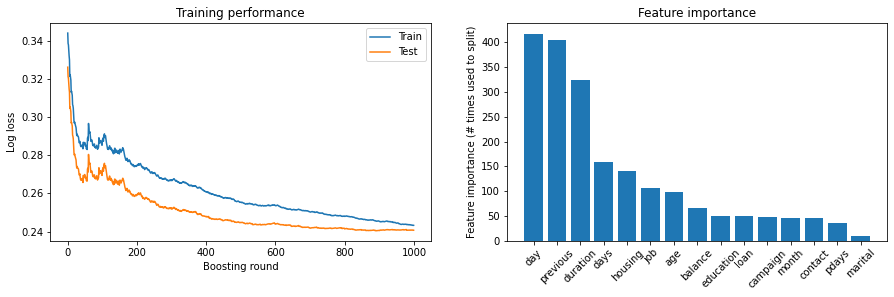

In [148]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': clf.feature_name(), 
                            'importance': clf.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'], rotation = 45)
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [149]:
importances.sort_values('importance')

,features,importance
2,marital,9
12,pdays,35
7,contact,45
9,month,46
11,campaign,47
3,education,50
6,loan,50
4,balance,66
0,age,99
1,job,106


In [150]:
preds = np.round(clf.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

Accuracy score = 	 0.9154716981132075
Precision score = 	 0.8125
Recall score =   	 0.2746478873239437
F1 score =      	 0.4105263157894737


## 推論

In [151]:
test_pred = clf.predict(p_test_df, num_iteration=optimum_boost_rounds)

In [152]:
p_test_df['poutcome'] = test_pred
p_train_df['poutcome'] = y

p_train_df['y'] = py
p_test_df['y'] = pz

p_train_df.fillna(-1, inplace=True)
p_test_df.fillna(-1, inplace=True)

In [153]:
df_dict = {}
for name, group in pd.concat([p_train_df, p_test_df]).groupby('y'):
    df_dict[name] = group
    
y_train_df = pd.concat([df_dict[0], df_dict[1]])
y_test_df = df_dict[-1]

y_test_df.drop(['y'], axis=1, inplace=True)

In [154]:
y_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27100 entries, 8 to 27062
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        27100 non-null  int64  
 1   job        27100 non-null  int64  
 2   marital    27100 non-null  int64  
 3   education  27100 non-null  int64  
 4   balance    27100 non-null  int64  
 5   housing    27100 non-null  int64  
 6   loan       27100 non-null  int64  
 7   contact    27100 non-null  int64  
 8   day        27100 non-null  int64  
 9   month      27100 non-null  int64  
 10  duration   27100 non-null  float64
 11  campaign   27100 non-null  int64  
 12  pdays      27100 non-null  int64  
 13  previous   27100 non-null  int64  
 14  days       27100 non-null  int64  
 15  poutcome   27100 non-null  float64
 16  y          27100 non-null  float64
dtypes: float64(3), int64(14)
memory usage: 3.7 MB


In [155]:
y_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18050 entries, 0 to 18049
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        18050 non-null  int64  
 1   job        18050 non-null  int64  
 2   marital    18050 non-null  int64  
 3   education  18050 non-null  int64  
 4   balance    18050 non-null  int64  
 5   housing    18050 non-null  int64  
 6   loan       18050 non-null  int64  
 7   contact    18050 non-null  int64  
 8   day        18050 non-null  int64  
 9   month      18050 non-null  int64  
 10  duration   18050 non-null  float64
 11  campaign   18050 non-null  int64  
 12  pdays      18050 non-null  int64  
 13  previous   18050 non-null  int64  
 14  days       18050 non-null  int64  
 15  poutcome   18050 non-null  float64
dtypes: float64(2), int64(14)
memory usage: 2.3 MB


In [157]:
y_train_df.describe()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,days,poutcome,y
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000
mean,36.073284,5.152509,1.386162,2.046125,47682.901771,0.583727,0.127269,0.788007,16.700443,6.003542,5.154210,1.775830,432.482399,0.085720,202.810258,0.093498,0.077934
std,7.816417,2.669990,0.872384,0.727044,31650.760036,0.492949,0.333281,0.498535,8.576252,2.135158,0.772170,0.950045,252.150648,0.365889,66.135046,0.143450,0.268072
min,22.000000,2.000000,0.000000,0.000000,-6847.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,34.000000,0.000000,0.000000
25%,31.000000,3.000000,0.000000,2.000000,20015.750000,0.000000,0.000000,0.000000,8.000000,5.000000,4.804021,1.000000,214.000000,0.000000,170.000000,0.025321,0.000000
50%,33.000000,5.000000,2.000000,2.000000,47624.000000,1.000000,0.000000,1.000000,17.000000,5.000000,5.068904,1.000000,432.000000,0.000000,182.000000,0.052116,0.000000
75%,37.000000,7.000000,2.000000,2.000000,75330.000000,1.000000,0.000000,1.000000,26.000000,7.000000,5.846439,2.000000,650.000000,0.000000,234.000000,0.115853,0.000000
max,90.000000,12.000000,2.000000,3.000000,102121.000000,1.000000,1.000000,2.000000,31.000000,12.000000,8.031710,5.000000,870.000000,3.000000,373.000000,1.000000,1.000000


In [158]:
y_test_df.describe()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,days,poutcome
count,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000
mean,36.104266,5.120388,1.382161,2.039501,47158.451801,0.577175,0.128587,0.783989,16.697950,5.998726,5.149830,1.770083,436.171801,0.090859,202.658449,0.093597
std,7.863805,2.650421,0.873514,0.717774,31469.525699,0.494022,0.334752,0.504881,8.580203,2.118452,0.781723,0.944872,251.392519,0.375801,65.583220,0.142955
min,20.000000,1.000000,0.000000,0.000000,-6838.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,34.000000,0.000000
25%,31.000000,3.000000,0.000000,2.000000,19654.500000,0.000000,0.000000,0.000000,8.000000,5.000000,4.804021,1.000000,219.250000,0.000000,170.000000,0.025928
50%,33.000000,5.000000,2.000000,2.000000,46886.000000,1.000000,0.000000,1.000000,17.000000,5.000000,5.068904,1.000000,436.000000,0.000000,182.000000,0.052890
75%,37.000000,7.000000,2.000000,2.000000,74178.000000,1.000000,0.000000,1.000000,26.000000,7.000000,5.846439,2.000000,654.000000,0.000000,234.000000,0.115518
max,90.000000,12.000000,2.000000,3.000000,102124.000000,1.000000,1.000000,2.000000,31.000000,12.000000,8.031710,4.000000,870.000000,3.000000,373.000000,1.000000


In [156]:
y_train_df.to_csv('y_train.csv', index=False)
y_test_df.to_csv('y_test.csv', index=False)